## Demande Loic + besoins Maxime 01/06 : fournir tableau de données pour visualisation principale n3 pour aider à l'écriture / à la formalisation de maquettes

## Cécile : fait, pas de soucis particulier
#### Tableau 1 (données Navigo) : 
pour chaque port DFLR en 1789 :
- nombre de bateaux sortis du port 
- tonnage moyen de ces bateaux

## Robin
#### Tableau 2.1 : (données Navigo, je ne sais pas encore comment ça se calcule)
pour chaque port DFLR en 1787 (pourrait se calculer correctement en 89 mais problème de cohérence des données avec tableau 2.2) : 
- indice de centralité dans le réseau des flux de la région

#### Tableau 2.2 : (données Navigo, je ne sais pas encore comment ça se calcule)
pour ports de La Rochelle, Bordeaux, Le Havre, Nantes en 1787 : 
- indice de centralité dans le réseau des flux de la France (et tester monde aussi)

#### ==> fournir à Maxime le réseau DFLR au format SVG (voir si pas déjà fait datasprint : export SVG avec Nansi)
#### fournir également fond de carte avec positionnement des ports : fournir Khartis déjà fait en SVG (dans dossier Drive Vizusprint)


## Cécile
#### Tableau 3.1.1 (données Navigo) : 
pour chaque port DFLR en 1789 (vérifier si ça change pas trop avec 87 mais normalement pas de soucis pour 89) : 
- tonnage cumulé à destination de l’extérieur de la région
- tonnage cumulé à destination de l’hinterland de la région

#### Tableau 3.1.2 (données Navigo)
pour les bureaux (agrégation de ports : retrouver les alignements ? pour l'instant je peux raisonner au niveau des amirautés) de La Rochelle, Bordeaux, Le Havre, Nantes en 1789 : 
- tonnage cumulé à destination de l’extérieur de la région
- tonnage cumulé à destination de l’hinterland (définir l'hinterland de chaque région) de la région

#### Tableau 3.2.1 (données Toflit) : 
pour bureau DFLR en 1789 : 
- valeur cumulée exports produits d'origine extérieure à la région
- valeur cumulée exports produits originaires de l’hinterland (PASA)

#### Tableau 3.2.2 (données Toflit) : 
pour bureaux de La Rochelle, Bordeaux, Le Havre, Nantes en 1789 : 
- valeur cumulée exports produits d'origine extérieure à la région
- valeur cumulée exports produits originaires de l’hinterland

####  alternative 1 : 1 tableau pour les 4 derniers (et laisser maxime faire les agrégations)
#### (alternative 2 : 1 ligne par bureau des fermes et une ligne par port)
=> besoin alignement bureau des Fermes de Bordeaux, LH, Nantes (pistes de sortie : regarder l'amirauté ? la direction ?)

In [1]:
# imports
import json 
import csv
from poitousprint import Portic, Toflit
from vega import VegaLite
import pandas as pd

portic_client = Portic()
toflit_client = Toflit()

#### Tableau 1 (données Navigo) : 
pour chaque port DFLR en 1789 :
- nombre de bateaux passés par le port 
- tonnage moyen de ces bateaux

In [2]:
# collecte des pointcalls sortis des ports de la DFLR en 1789 
pointcalls_ports_dflr_1789 = portic_client.get_pointcalls(
    year = 1789, 
    ferme_direction = 'La Rochelle', 
    pointcall_action = 'Out' 
)

print("nombre de pointcalls sortis des ports de la DFLR en 1789  :", len(pointcalls_ports_dflr_1789))

nombre de pointcalls sortis des ports de la DFLR en 1789  : 6540


In [3]:
ports_set = set() 
for p in pointcalls_ports_dflr_1789:
    ports_set.add(p['pointcall'])
print("nb de ports différents trouvés dans la DFLR : ", len(ports_set), " : ", ports_set)

nb de ports différents trouvés dans la DFLR :  25  :  {"Saint Michel en l' Herm", 'Beauvoir-sur-Mer', 'Ribérou [Saujon]', 'Noirmoutier', 'La Rochelle', 'Rochefort', 'La Flotte en Ré', 'Moricq', 'Ars en Ré', 'Royan', "Saint Denis [d' Oléron]", "Sables d' Olonne", 'La Perrotine', 'Mortagne', 'La Tranche sur Mer', 'Saint Gilles sur Vie', 'Charente', 'Soubise', 'Marennes', 'Saint Martin de Ré', 'Esnandes', "Le Chateau [d' Oléron]", 'La Tremblade', 'Champagné-les-Marais', 'Aligre de Marans'}


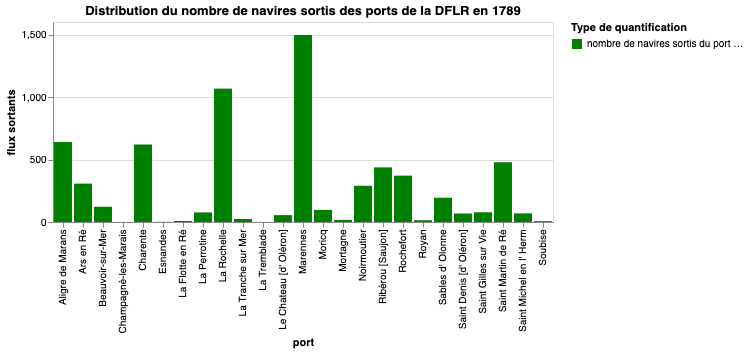

In [4]:
ports = {}

for p in ports_set:
    ports[p] = {
        "port": p,
        "nb_pointcalls_out":0,
        "cumulated_tonnage": 0,
        "mean_tonnage":0
    }


for p in pointcalls_ports_dflr_1789: 
    port = p['pointcall']
    if p['tonnage'] is not None:
        tonnage = int(p['tonnage'])
    else:
        tonnage = 0
    ports[port]['cumulated_tonnage'] += tonnage  
    ports[port]['nb_pointcalls_out'] += 1  

for port, values in ports.items():
    values['mean_tonnage'] = values['cumulated_tonnage'] / values['nb_pointcalls_out']

    
part_by_port = []
for port, values in ports.items():
    part_by_port.append({
        "port": port,
        "type": "nombre de navires sortis du port en 1789",
        "portion_nb_boats": values['nb_pointcalls_out'] 
    })
    part_by_port.append({
        "port": port,
        "type": "tonnage moyen des navires sortis du port en 1789",
        "portion_tonnage": values['mean_tonnage']
    })
  
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Distribution du nombre de navires sortis des ports de la DFLR en 1789",
    "mark": {"type": "bar", "tooltip": {"content": "data"}},
    "encoding": {
        "x": {
            "field": "port",
            "type": "ordinal", 
            "title": "port"
        },
        "y": {
            "type": "quantitative",
            "field": "portion_nb_boats",
            "title": "flux sortants"
        },
        "color": {
            "type": "nominal",
            "field": "type",
            "title": "Type de quantification",
            "scale": {
                 "range": ["green"]
            }
        }
    }
}, pd.DataFrame([p for p in part_by_port]))

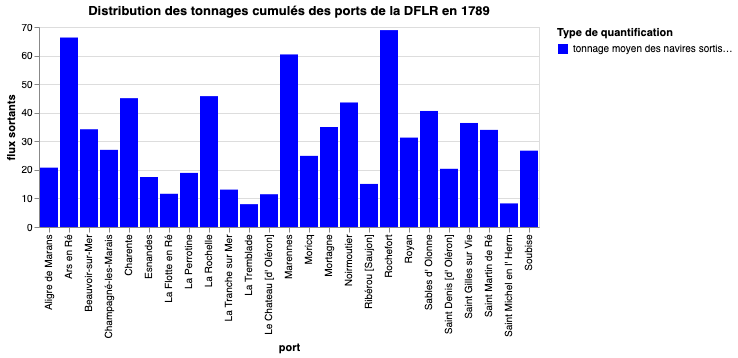

In [5]:
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Distribution des tonnages cumulés des ports de la DFLR en 1789",
    "mark": {"type": "bar", "tooltip": {"content": "data"}},
    "encoding": {
        "x": {
            "field": "port",
            "type": "ordinal", 
            "title": "port"
        },
        "y": {
            "type": "quantitative",
            "field": "portion_tonnage",
            "title": "flux sortants"
        },
        "color": {
            "type": "nominal",
            "field": "type",
            "title": "Type de quantification",
            "scale": {
                 "range": ["blue"]
            }
        }
    }
}, pd.DataFrame([p for p in part_by_port]))

### Ecriture des résultats dans un CSV

In [6]:
with open('csv_outputs/tableau_1.csv', 'w', newline='') as csvfile:
        fieldnames = ['port', 'nb_pointcalls_out', 'mean_tonnage','cumulated_tonnage']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for port, values in ports.items(): # port est une key, values est un dictionnaire python
            writer.writerow(values)

#### Tableau 3 (données Navigo & Toflit) :  v1 naïve
pour chaque port DFLR + ports Bordeaux, Le Havre, Nantes en 1789 (vérifier si ça change pas trop avec 87 aec Navigo mais normalement pas de soucis pour 89) : 
- tonnage cumulé à destination de l’extérieur de la région (Navigo)
- tonnage cumulé à destination de l’hinterland de la région (seulement province propre pour LH, B & N) (Navigo)
- valeur cumulée exports produits d'origine extérieure à la région (Toflit)
- valeur cumulée exports produits originaires de l’hinterland (Toflit)

#### Itérations pour trouver les bonnes données navigo

In [7]:
# collecte des pointcalls sortis des ports de la DFLR en 1789 
pointcalls_ports_dflr_1789 = portic_client.get_pointcalls(
    year = 1789, 
    ferme_direction = 'La Rochelle', 
    pointcall_action = 'Out' 
)

print("nombre de pointcalls sortis des ports de la DFLR en 1789  :", len(pointcalls_ports_dflr_1789))

# collecte des pointcalls sortis des ports de Bordeaux, La Rochelle et Le Havre en 1789
pointcalls_bordeaux_lehavre_nantes_1789 = portic_client.get_pointcalls(
    year = 1789, 
    pointcall = ['Bordeaux', 'Nantes', 'Le Havre'], 
    pointcall_action = 'Out' 
)

print("nombre de pointcalls sortis des ports de Bordeaux, La Rochelle et Le Havre en 1789  :", len(pointcalls_bordeaux_lehavre_nantes_1789))

nombre de pointcalls sortis des ports de la DFLR en 1789  : 6540
nombre de pointcalls sortis des ports de Bordeaux, La Rochelle et Le Havre en 1789  : 29


### attention on n'a pas les données pour les ports hors région en 89 => on part sur données 87 au moins pour les ports hors région

In [8]:
# collecte des pointcalls sortis des ports de la DFLR en 1787 
pointcalls_ports_dflr_1787 = portic_client.get_pointcalls(
    year = 1787, 
    ferme_direction = 'La Rochelle', 
    pointcall_action = 'Out' 
)

print("nombre de pointcalls sortis des ports de la DFLR en 1787  :", len(pointcalls_ports_dflr_1787))

nombre de pointcalls sortis des ports de la DFLR en 1787  : 6767


In [9]:
# collecte des pointcalls sortis des ports de Bordeaux, La Rochelle et Le Havre en 1787
pointcalls_bordeaux_lehavre_nantes_1787 = portic_client.get_pointcalls(
    year = 1787, 
    pointcall = ['Bordeaux', 'Nantes', 'Le Havre'], 
    pointcall_action = 'Out' 
)

print("nombre de pointcalls sortis des ports de Bordeaux, La Rochelle et Le Havre en 1787  :", len(pointcalls_bordeaux_lehavre_nantes_1787))

nombre de pointcalls sortis des ports de Bordeaux, La Rochelle et Le Havre en 1787  : 5655


In [10]:
ports_set = set() 
for p in pointcalls_ports_dflr_1789+pointcalls_bordeaux_lehavre_nantes_1787:
    ports_set.add(p['pointcall'])
print("nb de ports différents trouvés dans la DFLR + nos 3 ports : ", len(ports_set), " : ", ports_set)

nb de ports différents trouvés dans la DFLR + nos 3 ports :  28  :  {"Saint Michel en l' Herm", 'Beauvoir-sur-Mer', 'Le Havre', 'Ribérou [Saujon]', 'Noirmoutier', 'Nantes', 'La Rochelle', 'Rochefort', 'La Flotte en Ré', 'Moricq', 'Ars en Ré', 'Royan', "Saint Denis [d' Oléron]", "Sables d' Olonne", 'La Perrotine', 'Mortagne', 'La Tranche sur Mer', 'Saint Gilles sur Vie', 'Charente', 'Soubise', 'Marennes', 'Saint Martin de Ré', 'Esnandes', "Le Chateau [d' Oléron]", 'La Tremblade', 'Champagné-les-Marais', 'Bordeaux', 'Aligre de Marans'}


### je pense raisonner avec les flows si on utilise les données de 87 (attnetion on n'a beaucoup moins de données qu'avec les pointcalls il semblerait) (en ayant ajouté les tonnages ça bouge beaucoup déjà, sans params ça ne semble pas fonctionner, ...)

In [11]:
# imports
import json 
import csv
from poitousprint import Portic, Toflit
from vega import VegaLite
import pandas as pd

portic_client = Portic()
toflit_client = Toflit()

In [12]:
flows_from_ports_dflr_1787 = portic_client.get_flows(
    year = 1787,
    departure_ferme_direction = 'La Rochelle',
    params = ['tonnage', 'distance_dep_dest', 'departure', 'departure_ferme_direction', 'departure_province', 'departure_latitude', 'departure_longitude', 'destination', 'destination_ferme_direction', 'destination_province', 'destination_latitude', 'destination_longitude']
)
print(len(flows_from_ports_dflr_1787))

3128


In [13]:
flows_from_bordeaux_lehavre_nantes_1787 = portic_client.get_flows(
    year = 1787,
    departure = ['Bordeaux', 'Nantes', 'Le Havre'],
    params = ['tonnage','distance_dep_dest', 'departure', 'departure_ferme_direction', 'departure_province', 'departure_latitude', 'departure_longitude', 'destination', 'destination_ferme_direction', 'destination_province', 'destination_latitude', 'destination_longitude']
)
print(len(flows_from_bordeaux_lehavre_nantes_1787))

3363


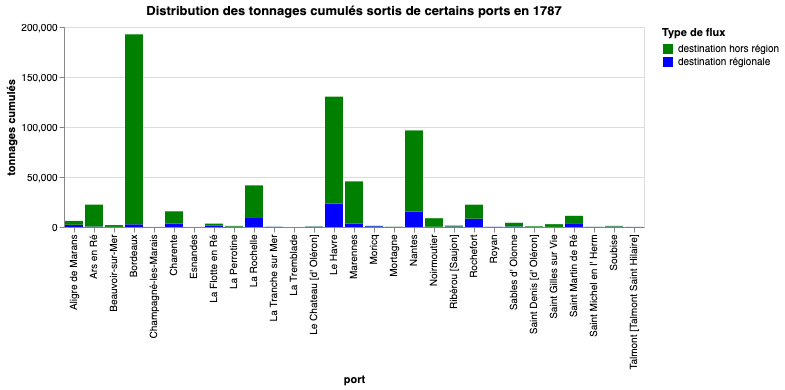

In [14]:
ports_set = {'Talmont [Talmont Saint Hilaire]','Soubise', 'Champagné-les-Marais', 'Aligre de Marans', 'Bordeaux', 'Ribérou [Saujon]', 'Le Havre', 'Ars en Ré', 'Beauvoir-sur-Mer', 'La Tranche sur Mer', "Saint Denis [d' Oléron]", "Sables d' Olonne", 'La Tremblade', 'Charente', 'Saint Martin de Ré', 'Moricq', 'Rochefort', "Saint Michel en l' Herm", 'Noirmoutier', "Le Chateau [d' Oléron]", 'Nantes', 'Saint Gilles sur Vie', 'Esnandes', 'Marennes', 'La Perrotine', 'La Flotte en Ré', 'La Rochelle', 'Royan', 'Mortagne'}

ports_tab_3 = {}
nb_flows_not_know_if_inside_or_outside_region = 0

for p in ports_set:
    ports_tab_3[p] = {
        "port": p,
        "nb_portic_flows_taken_into_account": 0,
        "nb_toflit_flows_taken_into_account": 0,
        "cumulated_tonnage_in_region": 0,
        "cumulated_tonnage_out_region": 0,
        "cumulated_exports_value_from_region": 0,
        "cumulated_exports_value_from_ext": 0
    }
    
for f in flows_from_ports_dflr_1787 + flows_from_bordeaux_lehavre_nantes_1787: 
    port = f['departure']
    if f['tonnage'] is not None:
        tonnage = int(f['tonnage'])
    else:
        tonnage = 0
    if f['departure_ferme_direction'] == 'La Rochelle':
        if f['destination_ferme_direction'] == 'La Rochelle':
            ports_tab_3[port]['cumulated_tonnage_in_region'] += tonnage  
        else:
            ports_tab_3[port]['cumulated_tonnage_out_region'] += tonnage  
    elif f['departure_province'] is not None: # dans ce cas là notre flow ne part pas de La Rochelle, besoin de distinguer cas bordeaux, nantes, le havre
          # j'espère que les provinces de départ d'arrivée sont renseignées dans ce cas là
        if f['departure_province'] == f['destination_province']:
            ports_tab_3[port]['cumulated_tonnage_in_region'] += tonnage
        else:
            ports_tab_3[port]['cumulated_tonnage_out_region'] += tonnage
    else:
        nb_flows_not_know_if_inside_or_outside_region += 1
    ports_tab_3[port]['nb_portic_flows_taken_into_account'] += 1  
    
# print("nb_flows_not_know_if_inside_or_outside_region : ", nb_flows_not_know_if_inside_or_outside_region,"\n\n")


# print(ports_tab_3)

tonnage_by_port = []
for port, values in ports_tab_3.items():
    tonnage_by_port.append({
        "port": port,
        "type": "destination régionale",
        "portion": values['cumulated_tonnage_in_region'] 
    })
    tonnage_by_port.append({
        "port": port,
        "type": "destination hors région",
        "portion": values['cumulated_tonnage_out_region']
    })
  
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Distribution des tonnages cumulés sortis de certains ports en 1787",
    "mark": {"type": "bar", "tooltip": {"content": "data"}},
    "encoding": {
        "x": {
            "field": "port",
            "type": "ordinal", 
            "title": "port"
        },
        "y": {
            "type": "quantitative",
            "field": "portion",
            "title": "tonnages cumulés"
        },
        "color": {
            "type": "nominal",
            "field": "type",
            "title": "Type de flux",
            "scale": {
                 "range": ["green", "blue"]
            }
        }
    }
}, pd.DataFrame([p for p in tonnage_by_port]))

#### on va maintenant chercher les données pertinentes chez Toflit => est ce que j'essaie de prendre en compte les flux attchés aux directions pertinentes mais pas au bureau des Fermes en particulier ??

In [15]:
flows_all_toflit_1789 = toflit_client.get_flows(
    year = 1789,
    export_import = 'Exports',
    customs_office = ['La Rochelle', 'Marennes', 'Rochefort', 'Saint-Martin-de-Ré',"Les Sables d'Olonne",'Aligre', 'Charente', 'Le Havre', 'Bordeaux', 'Nantes'] # on espère que la casse, l'orthographe est bonne
) 

## est ce que j'essaie de prendre en compte les flux attchés aux directions pertinentes mais pas au bureau des Fermes en particulier ??
print(len(flows_all_toflit_1789))

5113


In [16]:
print(flows_all_toflit_1789[0:10])

[{'line_number': '1', 'source_type': 'National toutes directions partenaires manquants', 'year': '1789', 'customs_region': 'Bordeaux', 'partner': 'Espagne', 'partner_orthographic': 'Espagne', 'export_import': 'Exports', 'product': 'Acier', 'product_orthographic': 'acier', 'value': '870', 'quantity': '29', 'quantity_unit': 'quintal', 'quantity_unit_orthographic': 'quintal', 'value_per_unit': '30', 'yearstr': '1789', 'customs_region_source': 'Bordeaux', 'customs_office': 'Bordeaux', 'origin_source': 'Etranger', 'width_in_line': '', 'value_part_of_bundle': '', 'filepath': 'sources/National toutes directions partenaires manquants/AN_F12_1666_Bordeaux_Exports_1789.csv', 'source': 'AN F12 1666', 'sheet': '2', 'value_total': '870', 'value_sub_total_1': '', 'value_sub_total_2': '', 'value_sub_total_3': '', 'data_collector': 'Jérémy Hervelin', 'unverified': '', 'remarks': '', 'value_minus_un_source': '0', 'absurd_observation': '', 'duty_quantity': '', 'duty_quantity_unit': '', 'duty_by_unit': '

## ! pour l'instant dans mes tableaux au niveau des valeurs Toflit il faut bien se souvenir qu'on raisonne pas exactement au niveau des ports mais des bureaux

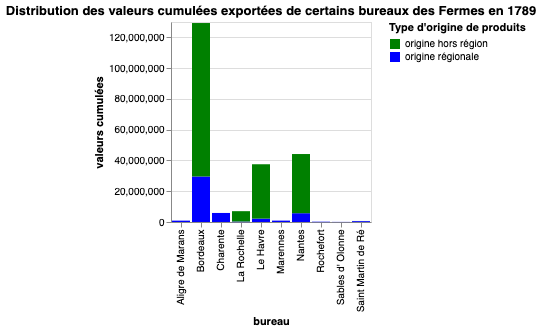

In [17]:
# si besoin de réinitialiser

for p in ports_tab_3:
    ports_tab_3[p]['cumulated_exports_value_from_region'] = 0
    ports_tab_3[p]['cumulated_exports_value_from_ext'] = 0
    ports_tab_3[p]['nb_toflit_flows_taken_into_account'] = 0

nb_not_know_origins = 0

# incohérences orthographiques à gérer
# Saint-Martin-de-Ré ≠ Saint Martin de Ré
# Les Sables d'Olonne ≠ Sables d' Olonne
# Aligre ≠ Aligre de Marans


for f in flows_all_toflit_1789:
    bureau = f['customs_office']
    # corriger l'orthographe
    if bureau == 'Saint-Martin-de-Ré': 
        bureau = 'Saint Martin de Ré'
    elif bureau == "Les Sables d'Olonne":
        bureau = "Sables d' Olonne"
    elif bureau == 'Aligre':
        bureau = 'Aligre de Marans'
        
    if f['value'] is not None and f['value'] != '':
        value = float(f['value'])
    else:
        value = 0
    if f['customs_region'] == 'La Rochelle': # j'espère que tous les flux de 89 venant d'un bureau de la DFLR ont cet attribut
        if f['origin_province'] in ['Aunis', 'Poitou', 'Saintonge', 'Angoumois']:
            ports_tab_3[bureau]['cumulated_exports_value_from_region'] += value  
        else:
            ports_tab_3[bureau]['cumulated_exports_value_from_ext'] += value
            if f['origin_province'] is None:
                nb_not_know_origins += 1
    else: # dans ce cas on est censés avoir un flux pas dans DFLR
        if f['customs_office'] in ['La Rochelle', 'Marennes', 'Rochefort', 'Saint-Martin-de-Ré',"Les Sables d'Olonne",'Aligre', 'Charente']:
            print("soucis") # si on a un flux DFLR c'est que filtre customs_region à changer
        if f['customs_office'] == 'Le Havre':
            if f['origin_province'] == 'Normandie':
                ports_tab_3[bureau]['cumulated_exports_value_from_region'] += value  
            else:
                ports_tab_3[bureau]['cumulated_exports_value_from_ext'] += value
                if f['origin_province'] is None:
                    nb_not_know_origins += 1
        elif f['customs_office'] == 'Bordeaux':
            if f['origin_province'] == 'Guyenne':
                ports_tab_3[bureau]['cumulated_exports_value_from_region'] += value  
            else:
                ports_tab_3[bureau]['cumulated_exports_value_from_ext'] += value
                if f['origin_province'] is None:
                    nb_not_know_origins += 1
        elif f['customs_office'] == 'Nantes':
            if f['origin_province'] == 'Bretagne':
                ports_tab_3[bureau]['cumulated_exports_value_from_region'] += value  
            else:
                ports_tab_3[bureau]['cumulated_exports_value_from_ext'] += value
                if f['origin_province'] is None:
                    nb_not_know_origins += 1
    ports_tab_3[bureau]['nb_toflit_flows_taken_into_account'] += 1  
    

# print(ports_tab_3)

value_by_bureau = []
for bureau, values in ports_tab_3.items():
    if bureau in ['La Rochelle', 'Marennes', 'Rochefort', 'Saint Martin de Ré',"Sables d' Olonne",'Aligre de Marans', 'Charente', 'Le Havre', 'Bordeaux', 'Nantes']: 
        value_by_bureau.append({
            "bureau": bureau,
            "type": "origine régionale",
            "portion": values['cumulated_exports_value_from_region'] 
        })
        value_by_bureau.append({
            "bureau": bureau,
            "type": "origine hors région",
            "portion": values['cumulated_exports_value_from_ext']
        })
  
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v5.json",
    "title": "Distribution des valeurs cumulées exportées de certains bureaux des Fermes en 1789",
    "mark": {"type": "bar", "tooltip": {"content": "data"}},
    "encoding": {
        "x": {
            "field": "bureau",
            "type": "ordinal", 
            "title": "bureau"
        },
        "y": {
            "type": "quantitative",
            "field": "portion",
            "title": "valeurs cumulées"
        },
        "color": {
            "type": "nominal",
            "field": "type",
            "title": "Type d'origine de produits",
            "scale": {
                 "range": ["green", "blue"]
            }
        }
    }
}, pd.DataFrame([b for b in value_by_bureau]))

### Ecriture des résultats dans un csv

In [19]:
with open('csv_outputs/tableau_3_1.csv', 'w', newline='') as csvfile:
        fieldnames = ['port', 'cumulated_tonnage_in_region', 'cumulated_tonnage_out_region', 'nb_portic_flows_taken_into_account']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for port, values in ports_tab_3.items(): # port est une key, values est un dictionnaire python
            writer.writerow({'port': values['port'], 'cumulated_tonnage_in_region': values['cumulated_tonnage_in_region'], 'cumulated_tonnage_out_region': values['cumulated_tonnage_out_region'], 'nb_portic_flows_taken_into_account': values['nb_portic_flows_taken_into_account']})

with open('csv_outputs/tableau_3_2.csv', 'w', newline='') as csvfile:
        fieldnames = ['customs_office','cumulated_exports_value_from_region', 'cumulated_exports_value_from_ext', 'nb_toflit_flows_taken_into_account']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        
        writer.writeheader()
        for bureau, values in ports_tab_3.items(): # bureau est une key, values est un dictionnaire python
            if bureau in ['La Rochelle', 'Marennes', 'Rochefort', 'Saint Martin de Ré',"Sables d' Olonne",'Aligre de Marans', 'Charente', 'Le Havre', 'Bordeaux', 'Nantes']:
                writer.writerow({'customs_office': values['port'], 'cumulated_exports_value_from_region': values['cumulated_exports_value_from_region'], 'cumulated_exports_value_from_ext': values['cumulated_exports_value_from_ext'], 'nb_toflit_flows_taken_into_account': values['nb_toflit_flows_taken_into_account']})